<a href="https://colab.research.google.com/github/ISPCGrupo3/Redes-Neuronales/blob/main/NNetF_B_Propag80x10x10_95x100SinEstandarizarOOKKK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Coding Neural Network - Forward Propagation and Backpropagation
</h1><br>

https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn

https://datascience-enthusiast.com/DL/Improving_DeepNeural_Networks_Regularization.html

http://neuralnetworksanddeeplearning.com/chap5.html

https://wiki.pathmind.com/neural-network

https://towardsdatascience.com/neural-network-architectures-156e5bad51ba

In [1]:
# Import packages
import os as os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Parameters Initialization
</h3><br>


In [2]:
# Initialize parameters
def initialize_parameters(layers_dims):
    """
    Initialize parameters dictionary.
    
    Weight matrices will be initialized to random values from uniform normal
    distribution.
    bias vectors will be initialized to zeros.

    Arguments
    ---------
    layers_dims : list or array-like
        dimensions of each layer in the network.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)

    return parameters

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Activation Functions
</h3><br>

In [3]:
# Define activation functions that will be used in forward propagation
def sigmoid(Z):
    """
    Computes the sigmoid of Z element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = 1 / (1 + np.exp(-Z))

    return A, Z


def tanh(Z):
    """
    Computes the Hyperbolic Tagent of Z elemnet-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.tanh(Z)

    return A, Z


def relu(Z):
    """
    Computes the Rectified Linear Unit (ReLU) element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0, Z)

    return A, Z


def leaky_relu(Z):
    """
    Computes Leaky Rectified Linear Unit element-wise.

    Arguments
    ---------
    Z : array
        output of affine transformation.

    Returns
    -------
    A : array
        post activation output.
    Z : array
        output of affine transformation.
    """
    A = np.maximum(0.1 * Z, Z)

    return A, Z

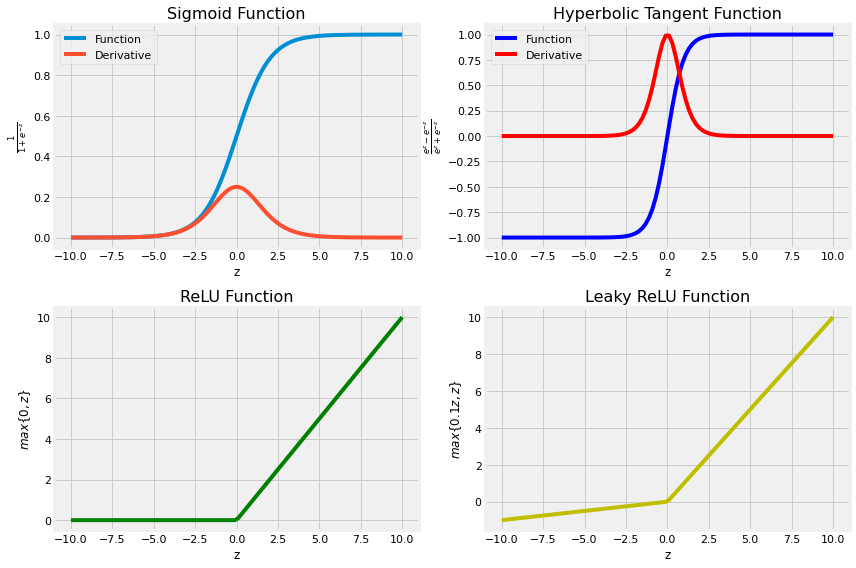

In [4]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label = "Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize = 16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label = "Derivative")
plt.legend(loc = "upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize = 16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize = 16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize = 16)
plt.tight_layout();

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Feed Forward
</h3><br>


In [5]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    """
    Computes affine transformation of the input.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.

    Returns
    -------
    Z : 2d-array
        affine transformation output.
    cache : tuple
        stores A_prev, W, b to be used in backpropagation.
    """
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    """
    Computes post-activation output using non-linear activation function.

    Arguments
    ---------
    A_prev : 2d-array
        activations output from previous layer.
    W : 2d-array
        weight matrix, shape: size of current layer x size of previuos layer.
    b : 2d-array
        bias vector, shape: size of current layer x 1.
    activation_fn : str
        non-linear activation function to be used: "sigmoid", "tanh", "relu".

    Returns
    -------
    A : 2d-array
        output of the activation function.
    cache : tuple
        stores linear_cache and activation_cache. ((A_prev, W, b), Z) to be used in backpropagation.
    """
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu"):
    """
    Computes the output layer through looping over all units in topological
    order.

    Arguments
    ---------
    X : 2d-array
        input matrix of shape input_size x training_examples.
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    caches : list
        that contains L tuples where each layer has: A_prev, W, b, Z.
    """
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])

    return AL, caches

<h3 style="font-family: Georgia; font-size:1.3em;color:purple; font-style:bold">
Cost
</h3><br>

https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function


In [6]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    """
    Computes the binary Cross-Entropy cost.

    Arguments
    ---------
    AL : 2d-array
        probability vector of shape 1 x training_examples.
    y : 2d-array
        true "label" vector.

    Returns
    -------
    cost : float
        binary cross-entropy cost.
    """
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))

    return cost

<h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Back-Propagation
</h2>

In [7]:
# Define derivative of activation functions w.r.t z that will be used in back-propagation
def sigmoid_gradient(dA, Z):
    """
    Computes the gradient of sigmoid output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    """
    Computes the gradient of hyperbolic tangent output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    """
    Computes the gradient of ReLU output w.r.t input Z.

    Arguments
    ---------
    dA : 2d-array
        post-activation gradient, of any shape.
    Z : 2d-array
        input used for the activation fn on this layer.

    Returns
    -------
    dZ : 2d-array
        gradient of the cost with respect to Z.
    """
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.

    Arguments
    ---------
    dZ : 2d-array
        gradient of the cost w.r.t. the linear output (of current layer l).
    cache : tuple
        values of (A_prev, W, b) coming from the forward propagation in the current layer.

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1).
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l).
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l).
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    """
    Arguments
    ---------
    dA : 2d-array
        post-activation gradient for current layer l.
    cache : tuple
        values of (linear_cache, activation_cache).
    activation : str
        activation used in this layer: "sigmoid", "tanh", or "relu".

    Returns
    -------
    dA_prev : 2d-array
        gradient of the cost w.r.t. the activation (of the previous layer l-1), same shape as A_prev.
    dW : 2d-array
        gradient of the cost w.r.t. W (current layer l), same shape as W.
    db : 2d-array
        gradient of the cost w.r.t. b (current layer l), same shape as b.
    """
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu"):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.

    Arguments
    ---------
    AL : 2d-array
        probability vector, output of the forward propagation (L_model_forward()).
    y : 2d-array
        true "label" vector (containing 0 if non-cat, 1 if cat).
    caches : list
        list of caches for all layers.
    hidden_layers_activation_fn :
        activation function used on hidden layers: "tanh", "relu".

    Returns
    -------
    grads : dict
        with the gradients.
    """
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], "sigmoid")

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)

    return grads


# define the function to update both weight matrices and bias vectors
def update_parameters(parameters, grads, learning_rate):
    """
    Update the parameters' values using gradient descent rule.

    Arguments
    ---------
    parameters : dict
        contains all the weight matrices and bias vectors for all layers.
    grads : dict
        stores all gradients (output of L_model_backward).

    Returns
    -------
    parameters : dict
        updated parameters.
    """
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

<a id="Application"></a>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
II. Application
</h2>

The dataset that we'll be working on has 209 images. Each image is 64 x 64 pixels on RGB scale. We'll build a neural network to classify if the image has a cat or not. Therefore, $y^i \in \{0, 1\}.$
- We'll first load the images.
- Show sample image for a cat.
- Reshape input matrix so that each column would be one example. Also, since each image is 64 x 64 x 3, we'll end up having 12,288 features for each image. Therefore, the input matrix would be 12,288 x 209.
- Standardize the data so that the gradients don't go out of control. Also, it will help hidden units have similar range of values. For now, we'll divide every pixel by 255 which shouldn't be an issue. However, it's better to standardize the data to have a mean of 0 and a standard deviation of 1.

In [8]:
X_train=np.random.randn(10,10)*1 + 1
l = [X_train]
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 1
    l.append(X)

In [9]:
X_train=np.random.randn(10,10)*1 + 1
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 1
    l.append(X)

In [10]:
X_train=np.random.randn(10,10)*1 + 1
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 1
    l.append(X)

In [11]:
X_train=np.random.randn(10,10)*1 + 1
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 1
    l.append(X)

In [12]:
X_train=np.random.randn(10,10)*1 + 20
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 20
    l.append(X)

In [13]:
X_train=np.random.randn(10,10)*1 + 20
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 20
    l.append(X)

In [14]:
X_train=np.random.randn(10,10)*1 + 20
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 20
    l.append(X)

In [15]:
X_train=np.random.randn(10,10)*1 + 20
l.append(X_train)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 20
    l.append(X)

In [16]:
l = np.array(l)
l.shape

(80, 10, 10)

In [17]:
X_train= l
#X_train

In [18]:
X_train[44:45]

array([[[20.14657748, 20.86276507, 21.24065633, 18.75374842,
         20.27565073, 20.46715891, 20.58586747, 21.27796588,
         19.17425131, 21.0331659 ],
        [18.00202893, 20.61024468, 22.09633678, 19.70655466,
         20.64116214, 18.93711787, 19.12596221, 20.40714912,
         20.4869774 , 19.64921283],
        [19.32497083, 19.63162035, 20.11693929, 19.82944959,
         21.62286124, 19.61760353, 18.95360687, 21.34201887,
         21.74601826, 20.65494547],
        [20.60727798, 19.43425636, 20.00950868, 20.1001093 ,
         19.83529543, 18.21064059, 21.12640756, 21.05016278,
         19.49154985, 21.9470738 ],
        [20.41119561, 20.74390834, 18.83712465, 19.66365193,
         21.03528162, 19.208969  , 18.92452691, 18.95577171,
         19.67085731, 20.45371606],
        [17.60610711, 20.41837858, 20.0417553 , 20.68481873,
         19.58525043, 18.59534581, 19.00074477, 19.63806906,
         21.84364985, 19.75448048],
        [20.00554033, 20.60380142, 19.62180974, 20.6

In [19]:
X_test=np.random.randn(10,10)*1 + 1
l = [X_test]
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 1
    l.append(X)

In [20]:
X_test=np.random.randn(10,10)*1 + 1
l.append(X_test)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 1
    l.append(X)

In [21]:
X_test=np.random.randn(10,10)*1 + 20
l.append(X_test)
for i in range(0,9):
    #print(i)
    X = np.random.randn(10,10)*1 + 20
    l.append(X)

In [22]:
X_test=np.random.randn(10,10)*1 + 20
l.append(X_test)
for i in range(0,10-1):
    #print(i)
    X = np.random.randn(10,10)*1 + 20
    l.append(X)

In [23]:
l = np.array(l)
l.shape

(40, 10, 10)

In [24]:
X_test=l
X_test.shape


(40, 10, 10)

In [25]:
y_train = np.array([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],                    
                    [1],[1],[1],[1],[1],[1],[1],[1],[1],[1],                    
                    [1],[1],[1],[1],[1],[1],[1],[1],[1],[1],                    
                    [1],[1],[1],[1],[1],[1],[1],[1],[1],[1],                    
                    [0],[0],[0],[0],[0],[0],[0],[0],[0],[0],
                    [0],[0],[0],[0],[0],[0],[0],[0],[0],[0],
                    [0],[0],[0],[0],[0],[0],[0],[0],[0],[0],
                    [0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])

y_train.shape         

(80, 1)

In [26]:
y_test = np.array([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],
                   [1],[1],[1],[1],[1],[1],[1],[1],[1],[1],
                   [0],[0],[0],[0],[0],[0],[0],[0],[0],[0],
                   [0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])                   

y_test.shape     

(40, 1)

In [27]:
# Import training dataset
#train_dataset = h5py.File("../data/train_catvnoncat.h5")
#X_train = np.array(train_dataset["train_set_x"])
#y_train = np.array(train_dataset["train_set_y"])

#test_dataset = h5py.File("../data/test_catvnoncat.h5")
#X_test = np.array(test_dataset["test_set_x"])
#y_test = np.array(test_dataset["test_set_y"])

# print the shape of input data and label vector
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

# plot cat image
#plt.figure(figsize=(6, 6))
#plt.imshow(X_train[50])
#plt.axis("off");


# Transform input data and label vector
X_train = X_train.reshape(80, -1).T
y_train = y_train.reshape(-1, 80)

X_test = X_test.reshape(40, -1).T
y_test = y_test.reshape(-1, 40)

# standarize the data
#X_train = X_train / 255
#X_test = X_test / 255

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

Original dimensions:
--------------------
Training: (80, 10, 10), (80, 1)
Test: (40, 10, 10), (40, 1)

New dimensions:
---------------
Training: (100, 80), (1, 80)
Test: (100, 40), (1, 40)


In [28]:
#X = np.array(df['deceduti']).reshape(-1,1)
#scaler = StandardScaler()
#scaler.fit(X)
#X_scaled = scaler.transform(X)

from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler1.fit(X_train)
X_scaled = scaler1.transform(X_train)
X_train=X_scaled

In [29]:
#X = np.array(df['deceduti']).reshape(-1,1)
#scaler = StandardScaler()
#scaler.fit(X)
#X_scaled = scaler.transform(X)

from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
scaler2.fit(X_test)
X_scaled2 = scaler2.transform(X_test)
X_test=X_scaled2

Now, our dataset is ready to be used and test our neural network implementation. Let's first write **multi-layer model** function to implement gradient-based learning using predefined number of iterations and learning rate.

In [30]:
# Define the multi-layer model using all the helper functions we wrote before


def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000, num_iterations1=20,
        print_cost=True, hidden_layers_activation_fn="relu"):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test examples.
    """
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for j in range(num_iterations1):
        learning_rate=learning_rate/2.5
        # iterate over num_iterations
        for i in range(num_iterations):
            # iterate over L-layers to get the final output and the cache
            AL, caches = L_model_forward(X, parameters, hidden_layers_activation_fn)
            # compute cost to plot it
            cost = compute_cost(AL, y)
            # iterate over L-layers backward to get gradients
            grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)
            # update parameters
            parameters = update_parameters(parameters, grads, learning_rate)
            # append each 100th cost to the cost list
            if (i + 1) % 100 == 0 and print_cost:
                print(f"The {j} cost after {i + 1} iterations is: {cost:.10f}")
            if i % 100 == 0:
                cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y, activation_fn="relu"):
    """
    Computes the average accuracy rate.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    parameters : dict
        learnt parameters.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".

    Returns
    -------
    accuracy : float
        accuracy rate after applying parameters on the input data
    """
    probs, caches = L_model_forward(X, parameters, activation_fn)
    print("probs: ", str(probs))
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100

    return f"The accuracy rate is: {accuracy:.2f}%."

Next, we'll train two versions of the neural network where each one will use different activation function on hidden layers: One will use rectified linear unit (**ReLU**) and the second one will use hyperbolic tangent function (**tanh**). Finally we'll use the parameters we get from both neural networks to classify test examples and compute the test accuracy rates for each version to see which activation function works best on this problem.

In [31]:
# Setting layers dims
layers_dims = [X_train.shape[0], 7,3, 1]

## TANH

The 0 cost after 100 iterations is: 0.6931465630
The 0 cost after 200 iterations is: 0.6931463963
The 0 cost after 300 iterations is: 0.6931462189
The 0 cost after 400 iterations is: 0.6931460292
The 0 cost after 500 iterations is: 0.6931458255
The 0 cost after 600 iterations is: 0.6931456057
The 0 cost after 700 iterations is: 0.6931453676
The 0 cost after 800 iterations is: 0.6931451088
The 0 cost after 900 iterations is: 0.6931448265
The 0 cost after 1000 iterations is: 0.6931445175
The 0 cost after 1100 iterations is: 0.6931441783
The 0 cost after 1200 iterations is: 0.6931438047
The 0 cost after 1300 iterations is: 0.6931433922
The 0 cost after 1400 iterations is: 0.6931429352
The 0 cost after 1500 iterations is: 0.6931424275
The 0 cost after 1600 iterations is: 0.6931418620
The 0 cost after 1700 iterations is: 0.6931412302
The 0 cost after 1800 iterations is: 0.6931405220
The 0 cost after 1900 iterations is: 0.6931397259
The 0 cost after 2000 iterations is: 0.6931388279
The 0 cos

'The accuracy rate is: 52.50%.'

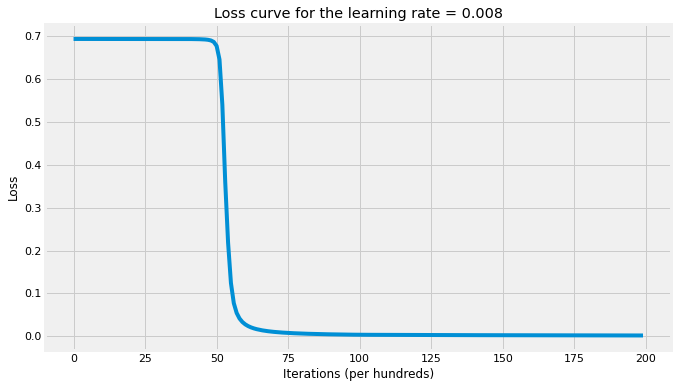

In [33]:

# NN with tanh activation fn
parameters_tanh = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.05, num_iterations=10000, num_iterations1=2,
    hidden_layers_activation_fn="tanh")

# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="tanh")

## RELU


In [ ]:
# NN with relu activation fn
parameters_relu = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.05, num_iterations=10000, num_iterations1=2,
    hidden_layers_activation_fn="relu")

# Print the accuracy
accuracy(X_test, parameters_relu, y_test, activation_fn="relu")

sigmoid

The 0 cost after 100 iterations is: 0.6931472672
The 0 cost after 200 iterations is: 0.6931471672
The 0 cost after 300 iterations is: 0.6931471494
The 0 cost after 400 iterations is: 0.6931471459
The 0 cost after 500 iterations is: 0.6931471448
The 0 cost after 600 iterations is: 0.6931471441
The 0 cost after 700 iterations is: 0.6931471435
The 0 cost after 800 iterations is: 0.6931471429
The 0 cost after 900 iterations is: 0.6931471423
The 0 cost after 1000 iterations is: 0.6931471417
The 0 cost after 1100 iterations is: 0.6931471411
The 0 cost after 1200 iterations is: 0.6931471405
The 0 cost after 1300 iterations is: 0.6931471399
The 0 cost after 1400 iterations is: 0.6931471393
The 0 cost after 1500 iterations is: 0.6931471387
The 0 cost after 1600 iterations is: 0.6931471381
The 0 cost after 1700 iterations is: 0.6931471375
The 0 cost after 1800 iterations is: 0.6931471369
The 0 cost after 1900 iterations is: 0.6931471363
The 0 cost after 2000 iterations is: 0.6931471357
The 0 cos

'The accuracy rate is: 50.00%.'

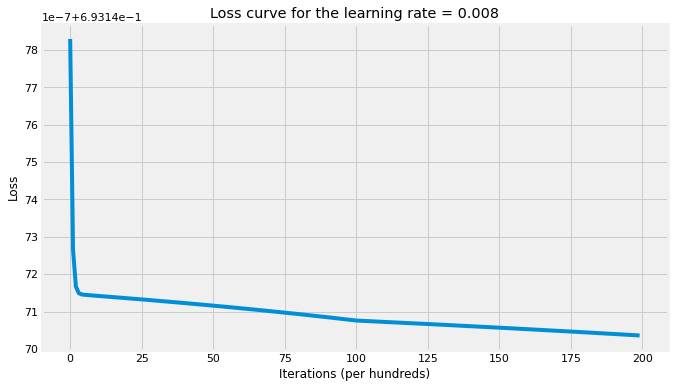

In [37]:
# NN with tanh activation fn
parameters_tanh = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.05, num_iterations=10000, num_iterations1=2,
    hidden_layers_activation_fn="sigmoid")

# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="sigmoid")

# Oscar

leaky_relu

In [ ]:
# NN with tanh activation fn
parameters_leaky_relu = L_layer_model(
    X_train, y_train, layers_dims, learning_rate=0.2, num_iterations=10000, num_iterations1=2,
    hidden_layers_activation_fn="leaky_relu")

# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="leaky_relu")